/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y:

/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)
/home/cloudera/.conda/envs/my_root/lib/python2.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y:

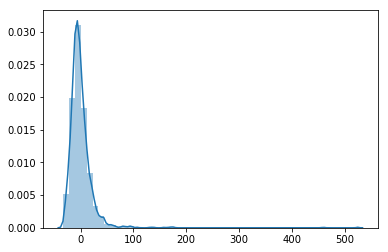

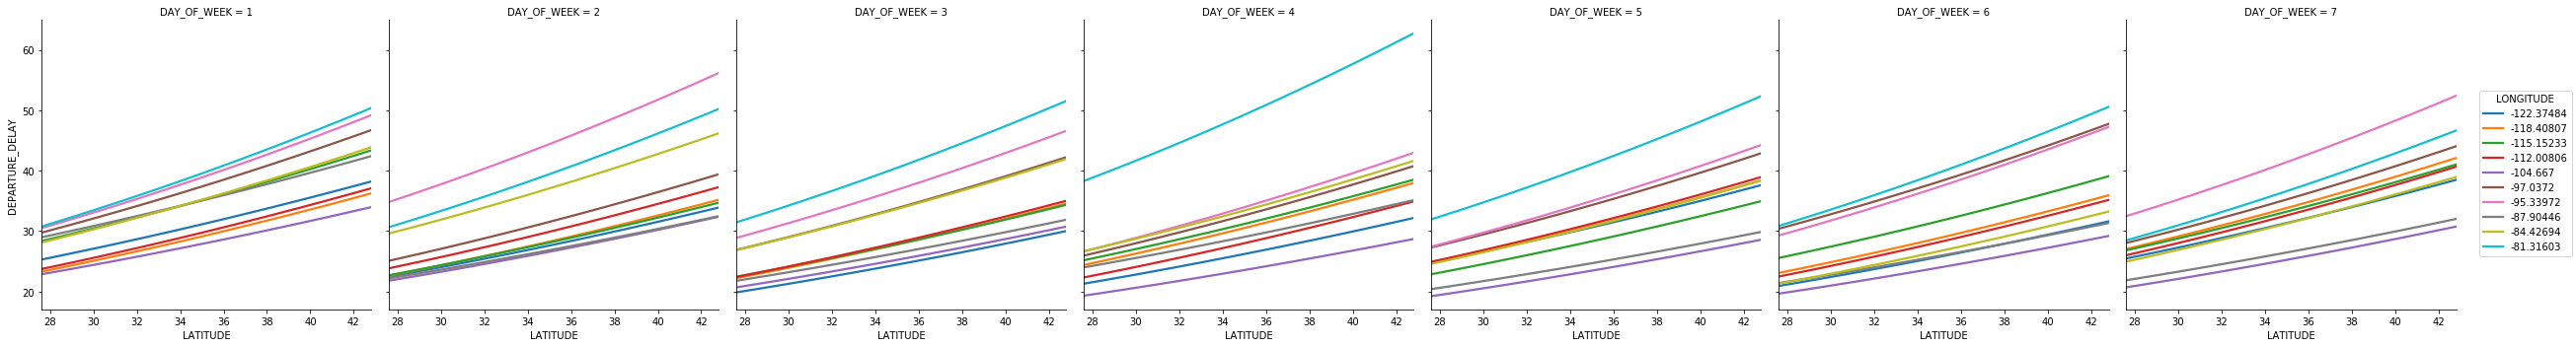

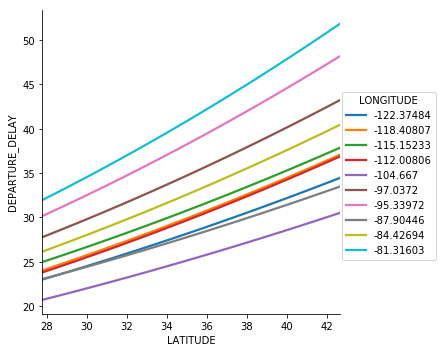

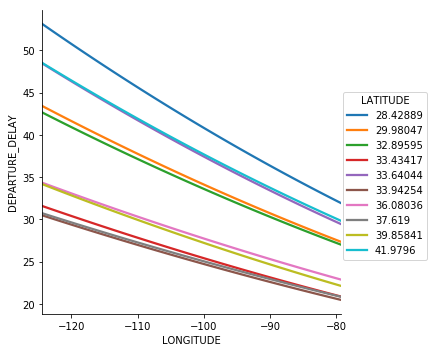

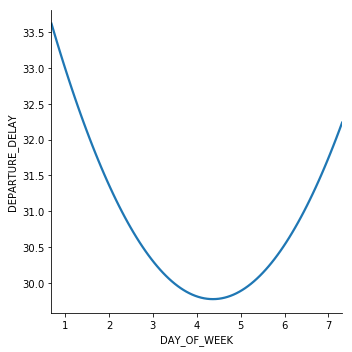

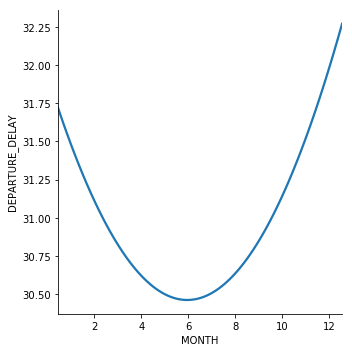

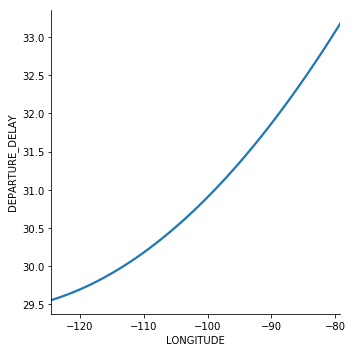

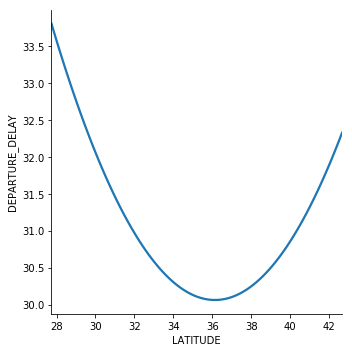

In [2]:
#import hdfs3 #unfortunately returns import error 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
from matplotlib.collections import LineCollection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
plt.rcParams.update({'figure.max_open_warning': 0})

#for the model learning part, load the full dataset (or the smaller ones)

#loading different subsets of the data
#result=pd.read_csv('flights_small.csv') #100 rows
#result=pd.read_csv('flights_10k.csv') #100 000 rows
#result=pd.read_csv('flights_1m.csv') #1 000 000 rows
result=pd.read_csv('flights.csv') #complete dataset ~5 800 000 rows

result['AIRLINE_ORIGIN_AIRPORT'] = result['AIRLINE'].astype(str) + result['ORIGIN_AIRPORT'].astype(str)

#convert the delays to numeric 
result['DEPARTURE_DELAY']=pd.to_numeric(result['DEPARTURE_DELAY']) #convert the delays

#We remove all the negative values, as this would disrupt our mean - hence our model

result=(result[result['DEPARTURE_DELAY'] >= 0])

#top 10 airports based on flights DEPARTING from there
top_airports=result.groupby(['ORIGIN_AIRPORT'], as_index=False)[['FLIGHT_NUMBER']] \
                            .count()\
                            .sort_values(['FLIGHT_NUMBER'], ascending=False)\
                            .head(10) #top 10 airports, you can change it to 20, 30, 40, 50 etc. airports
            
top_airports.rename(columns={'ORIGIN_AIRPORT':'IATA_CODE'},inplace=True)

#create a pivottable to have the mean delay for each company,airport, and day of week
table=pd.pivot_table(result,index=['AIRLINE','AIRLINE_ORIGIN_AIRPORT','ORIGIN_AIRPORT',"DAY_OF_WEEK","MONTH"],\
values=["DEPARTURE_DELAY"],\
aggfunc='mean',dropna=True) 

#read the airlines to get numerical value for each airline
airlines=pd.read_csv('airlines_num.csv')

#read airports to get the Longtitude and Latitude
airports=pd.read_csv('airports.csv')

airports['AIRPORT_NUM']=(airports.index.get_level_values(0)+1000)

#join the top airports with all airports to get the Longtitude and Latitude
airports=top_airports.merge(airports,on=['IATA_CODE'],how='left')#lsuffix='LATITUDE')

#remove unnecessary columns
airports.drop(['FLIGHT_NUMBER','AIRPORT','CITY','STATE','COUNTRY'], inplace=True,axis=1)

#rename the columns
airports.rename(columns={'IATA_CODE':'ORIGIN_AIRPORT'},inplace=True)

#the data we need for the regression is in the index values of the pivottable,
#so we create columns to store it
table['AIRLINE_ORIGIN_AIRPORT'] = table.index.get_level_values(1)#.map(lambda x: df2.newcol[x])
table['AIRLINE'] = table.index.get_level_values(0)
table['MONTH'] = table.index.get_level_values(-1)
table['DAY_OF_WEEK'] = table.index.get_level_values(-2)
table['ORIGIN_AIRPORT'] = table.index.get_level_values(-3)

#as in the pivottable we have means for all airports and all airlines,
#we join it on the top 50 airports table
aa = pd.merge(table, airports, 'right')

airlines.rename(columns={'AIRLINE':'AIRLINE_STRING'},inplace=True)
airlines.rename(columns={'IATA_CODE':'AIRLINE',"NUM_VALUE":"AIRLINE_NUM_VALUE"},inplace=True)

aa=aa.merge(airlines,on=['AIRLINE'],how='left')

aa['AIRLINE_NUM_VALUE']=pd.to_numeric(aa['AIRLINE_NUM_VALUE'])
aa['LATITUDE']=pd.to_numeric(aa['LATITUDE'])
aa['LONGITUDE']=pd.to_numeric(aa['LONGITUDE'])
aa['MONTH']=pd.to_numeric(aa['MONTH'])
aa['DAY_OF_WEEK']=pd.to_numeric(aa['DAY_OF_WEEK'])
aa['DEPARTURE_DELAY']=pd.to_numeric(aa['DEPARTURE_DELAY'])
aa['AIRPORT_NUM']=pd.to_numeric(aa['AIRPORT_NUM'])

#VERY IMPORTANT:
#CONVERT THE AVERAGES TO FLOAT, OTHERWISE THE MODEL CANNOT LEARN FROM THEM!!!
aa['DEPARTURE_DELAY'] = aa['DEPARTURE_DELAY'].astype(float).fillna(0.0)

#the factors (independent variable)
X = aa[['MONTH','DAY_OF_WEEK','AIRLINE_NUM_VALUE','LATITUDE','LONGITUDE']]

#the dependet variable (what we would like to predict\explain)
y = aa[['DEPARTURE_DELAY']]

##training the model
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.25,random_state=0) #75/25 split

model = LinearRegression()
model.fit(X_train, y_train)

predictions=model.predict(X_test)

linear_regression=LinearRegression()


sns.distplot(y_test-predictions)

#we ploted the deviations from the predictions
sns.regplot(x='AIRLINE_NUM_VALUE',y='DEPARTURE_DELAY',data=aa) #plot the regression
one=sns.lmplot(x='LATITUDE', y="DEPARTURE_DELAY", hue='LONGITUDE', data=aa,col='DAY_OF_WEEK',\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

two=sns.lmplot(x='LATITUDE', y="DEPARTURE_DELAY", hue='LONGITUDE', data=aa,\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

four=sns.lmplot(x='LONGITUDE', y="DEPARTURE_DELAY", hue='LATITUDE', data=aa,\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

five=sns.lmplot(x='DAY_OF_WEEK', y="DEPARTURE_DELAY", data=aa,\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

five=sns.lmplot(x='MONTH', y="DEPARTURE_DELAY", data=aa,\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

six=sns.lmplot(x='LONGITUDE', y="DEPARTURE_DELAY", data=aa,\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

seven=sns.lmplot(x='LATITUDE', y="DEPARTURE_DELAY", data=aa,\
           scatter=False,fit_reg=True,order=2,\
           ci=None)

plt.show()

#different tries for plot outputs

# sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1})

# sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})

# sns.regplot(x="LONGITUDE", y="DEPARTURE_DELAY", data=aa,ci=None, scatter_kws={"s": 80})

# sns.regplot(x="LATITUDE", y="DEPARTURE_DELAY", data=aa,ci=None, scatter_kws={"s": 80})

# sns.regplot(x="DAY_OF_WEEK", y="DEPARTURE_DELAY", data=aa,ci=None, scatter_kws={"s": 80})

# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

#sns.jointplot(x="AIRLINE_NUM_VALUE", y="DEPARTURE_DELAY", data=aa, kind="reg")

#sns.lmplot(x="AIRLINE_NUM_VALUE", y="DEPARTURE_DELAY", col="DAY_OF_WEEK", data=aa)#,aspect=.5);

#sns.jointplot(x="AIRPORT_NUM", y="DEPARTURE_DELAY", data=aa, kind="reg")

#sns.lmplot(x="AIRPORT_NUM", y="DEPARTURE_DELAY", col="DAY_OF_WEEK", data=aa)#,aspect=.5);

In [ ]:
from kafka import KafkaConsumer, KafkaClient
from kafka import TopicPartition
import numpy as np
import pandas as pd
import json

print('Start')
consumer0302=KafkaConsumer('topic0302', bootstrap_servers=['localhost:9092'])

#create our first data frame, columns only, no index, no data 
#df=pd.DataFrame(columns=columns)

def airline_num(airline):
    """The function returns the numerical values for each airline"""
    if airline == "UA":
        airnum=1
    elif airline =='AA':
        airnum=2
    elif airline == 'US':
        airnum=3
    elif airline =='F9':
        airnum=4
    elif airline == 'B6':
        airnum=5
    elif airline =='OO':
        airnum=6
    elif airline == 'AS':
        airnum=7
    elif airline =='NK':
        airnum=8
    elif airline == 'WN':
        airnum=9
    elif airline =='DL':
        airnum=10
    elif airline == 'EV':
        airnum=11
    elif airline == 'HA':
        airnum=12
    elif airline == 'MQ':
        airnum=13
    elif airline == 'VX':
        airnum=14
    else:
        airnum=0
    return airnum

ls=[]

print("Starting the loop")
k=0
#we create an empty list, in which we will insert each dataframe
for msg in consumer0302:
    test = msg.value.split()
    test=[i.replace('"','') for i in test]
    test=[i.replace(",",'') for i in test]
    test=[i.replace("[",'') for i in test]
    test=[i.replace("]",'') for i in test]
    month=test[1]
    dow=test[3]
    airline=test[4]
    airport=test[7]
    sql=(aa[aa['ORIGIN_AIRPORT'] == airport]).head(1)
    #as the model only learns on the top 10 airports, any message that includes a flight departing from another 
    #tier 2 or tier 3 airport would be ignored
    if sql.empty==True:
        print("For the flight "+test[4]+test[5]+" scheduled for departure from "\
          +test[7]\
          +" a prediction could not be made, as the airport is not a top 50 airport")
        continue
    else:
        pass
    airport_lat=sql.iloc[:,6]
    airport_lon=sql.iloc[:,7]
    airline=airline_num(test[4])
    
    alon = airport_lon.as_matrix()
    alat = airport_lat.as_matrix()
    x = np.array([month,dow])
    n = np.array([airline])
    z = np.concatenate((x,alat,alon,n), axis=0)

    z_float=z.astype(np.float)

    myvals = z_float.reshape(1,-1)
    #print(myvals)
    prediction=model.predict(myvals)
    string=str(prediction)
    
    #dfl=pd.DataFrame(scheduledstr,index=columns)
    df2 = pd.DataFrame({'PREDICTED DEPARTURE_DELAY' : string[2:8],\
                        'AIRLINE_ORIGIN_AIRPORT' : test[4]+"_"+test[7],\
                        'MONTH' : month,\
                        'DAY_OF_WEEK' : dow,\
                        'LATITUDE' : airport_lat,\
                         'LONGITUDE' : airport_lon,\
                         'AIRLINE_NUM_VALUE' : airline})

    ls.append(df2)
    
    print("The flight "+test[4]+test[5]+" scheduled for departure from "\
          +test[7]\
          +" could be possibly delayed by"+string[2:8]+" minutes.")
    